In [22]:

import pandas as pd
import numpy as np
import random
import math
from numpy import random
import cmath
import matplotlib.pyplot as plt


# Load datasets related to Base Stations, UAVs, and Clients
base = pd.read_csv(r'BS_data.csv')
uav = pd.read_csv(r'UAV_data.csv')
people = pd.read_csv(r'people_data.csv')
IRS=pd.read_csv(r'IRS_data.csv')
p_km_UP=pd.read_csv(r'P_km_up.csv')

Angle_df=pd.read_csv(r'Angle.csv') # number of IRS is 500 store in each column
h_l_km_df=pd.read_csv(r'h_l_km.csv') # number of IRS is 500 store in each column
h_l_m_df=pd.read_csv(r'h_l_m.csv') # number of IRS is 500 store in each column

Angle_UP_df=pd.read_csv(r'Angle1.csv') # number of IRS is 500 store in each column
g_l_km_df=pd.read_csv(r'h_l_km1.csv') # number of IRS is 500 store in each column
g_l_m_df=pd.read_csv(r'h_l_m1.csv') # number of IRS is 500 store in each column # corrected filename

Angle_har_df=pd.read_csv(r'Angle2.csv') # number of IRS is 500 store in each column
f_l_km_df=pd.read_csv(r'h_l_km2.csv') # number of IRS is 500 store in each column
f_l_m_df=pd.read_csv(r'h_l_m2.csv') # number of IRS is 500 store in each column # corrected filename
f_km1=pd.read_csv(r'f_km.csv')

# Constants
Wl = 35.28
H_value = 20
P_m_har = base['P_m_har']
T_m_har = base['T_m_har']
P_m_down = base['P_m_down']
f_km=f_km1['0']
V_lm_vfly = uav['V_lm_vfly']
V_lm_hfly = uav['V_lm_hfly']
D_l_hfly_value=100

P_km_up=p_km_UP['0']
p_max=10 # moved inside loop
p_km_max=2.5
T_m=10


# Additional constants for calculations
delta = 0.012
Ar = 0.1256
s = 0.05
Nr = 4
V_tip = 102
Cd = 0.022
Af = 0.2113
D_km = 0.5
# Dm=0.49
B=10 #MHz
sigma_km=10**(-13)
eta=10
kappa=0.5
num_population=50
Bh = (1 - 2.2558 * pow(10, -5) *H_value)**4.2577
# Bh = max(1, Bh)
p_l_b = (delta / 8) * Bh * Ar * s * pow(V_tip, 3)

# Determine the maximum possible rows based on the smallest dataframe size
min_rows = min(len(Angle_df), len(h_l_km_df), len(h_l_m_df), len(Angle_UP_df), len(g_l_km_df), len(g_l_m_df), len(Angle_har_df), len(f_l_km_df), len(f_l_m_df), len(f_km1))
num_rows_data_files = min_rows # Dynamically set num_rows_data_files based on the smallest dataframe length
population_size = min(50, num_rows_data_files) # Ensure population_size is not larger than available data


In [23]:
print(Bh)

0.998080507207233


In [24]:
# Fitness function to calculate total energy consumption
def Fitness(E_ml_har, E_ml_down, E_ml_UAV):
    return E_ml_har + E_ml_down + E_ml_UAV

# Energy consumption of the UAV-IRS
def E_ml_UAV(P_l_vfly, T_l_vfly, P_lm_hfly, T_l_hfly, P_l_hov, T_lm_hov):
    return P_l_vfly * T_l_vfly + P_lm_hfly * T_l_hfly + P_l_hov * T_lm_hov

# Power calculations for different flight modes
def P_l_vfly(Wl, V_l_vfly, P_l_b, Nr, Ar, Bh):
    temp2 = Nr * Bh * Ar
    temp3 = np.sqrt(V_l_vfly**2 + (2 * Wl) / temp2)
    return ((Wl / 2) * (V_l_vfly + temp3)) + Nr * P_l_b

def P_lm_hfly(P_lm_blade, P_lm_fuselage, P_lm_induced):
    return P_lm_blade + P_lm_fuselage + P_lm_induced

def P_lm_blade(Nr, P_l_b, V_tip, V_lm_hfly):
    return Nr * P_l_b * (1 + ((3 * (V_lm_hfly**2)) / pow(V_tip, 2)))

def P_lm_fuselage(Cd, Af, Bh, V_lm_hfly):
    return (1 / 2) * Cd * Af * Bh * (V_lm_hfly**3)

def P_lm_induced(Nr, Bh, Ar, Wl, V_lm_hfly):
    return Wl * ((np.sqrt((Wl**2) / (4 * (Nr**2) * (Bh**2) * (Ar**2)) + ((V_lm_hfly**4) / 4))) - ((V_lm_hfly**2) / 2))**(1 / 2)

def P_l_hov(Wl, P_l_b, Nr, Ar, Bh):
    temp1 = Nr * P_l_b
    temp3 = np.sqrt((2 * (Nr * Bh * Ar)))
    temp4 = ((Wl)**3 / 2) / temp3
    return temp1 + temp4

def T_lm_hov(T_km_com, T_kml_up, T_ml_down):
    return T_km_com + T_kml_up + T_ml_down

def R_ml_down(B,P_m_down,h_ml_worst): #eqation number 7
    if P_m_down<=0:
        P_m_down=random.uniform(0,10)
    temp1=(h_ml_worst*P_m_down) # Consider if min is the correct aggregation. It should be multiplication
    # if (1+temp1) <= 0:  # P_m_down may be go to negative in mutaion or crossover
    #     return 0  # Return 0 if log argument is non-positive to avoid error
    return B*math.log2(1+temp1)

def h_ml_worst(h_kml_down,sigma_km): #eqation number 8
    return h_kml_down/(sigma_km) # it will return the sigal value which is minimum of all
            # the value for each itaration

def calculate_exp_i_theta(theta): # part of equation 8
  return cmath.exp(1j * theta)
 # 1j represents the imaginary unit in Python

def h_kml_down(Angle,h_l_m,h_l_km): # part of equation 8
    result=[]
    if isinstance(Angle, float): # Check if Angle is float, if so, return 0 or handle appropriately
        return 0 # Or raise an exception or return a default value as needed

    if not isinstance(Angle, pd.Series): # added check to handle non-series input
        raise TypeError(f"Expected Angle to be pd.Series, got {type(Angle)}")

    for i in range(len(Angle)):
        theta_radians = math.radians(Angle.iloc[i]) # Use iloc for position-based indexing
        results= calculate_exp_i_theta(theta_radians)
        result.append(results)

    diagonal=np.diag(result)
    # Ensure h_l_m and h_l_km are correctly formatted as numpy arrays
    h_l_m_np = h_l_m.to_numpy() # Convert Series to numpy array
    h_l_km_np = h_l_km.to_numpy() # Convert Series to numpy array
    if h_l_m_np.ndim == 1:
        h_l_m_np = h_l_m_np.reshape(-1, 1) # Reshape to 2D if necessary
    if h_l_km_np.ndim == 1:
        h_l_km_np = h_l_km_np.reshape(1, -1) # Reshape to 2D if necessary


    a=np.dot(h_l_km_np,diagonal) # Use numpy arrays for dot product
    b=np.dot(a,h_l_m_np)      # Use numpy arrays for dot product
    final=abs(b[0][0]) # Take absolute value and ensure it's a scalar
    return (final**2)

def R_kml_up(B,P_km_up,h_kml_up,Sub,sigma_m): #eqation number 4
    temp1=(P_km_up*h_kml_up)/ (Sub+(sigma_m))
    return B*math.log2(1+temp1)
#this is inside the equation 4 have to take summation of h_i_up and P_i_up
def sub(P_i_up,h_il_up):
    return P_i_up*h_il_up

def E_km_com(f_km,T_km_com):
    return eta*(10**(-28))*(f_km**3)*T_km_com

def E_kml_up(P_km_up,T_km_up):
    return P_km_up*T_km_up

def E_kml_har(P_m_har,T_m_har,h_km_har):
    return kappa*P_m_har*T_m_har*h_km_har


In [25]:
num_bs = 5
num_irs_ele=50
num_generation = 1 # Number of iterations for Hill Climbing
num_uav_irs = 8
population_size = 50 # Initial population size (used for initial solution in HC)

# Define keys that should be subjected to perturbation (numerical parameters)
numerical_keys_for_hc = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','f_km_value','Angle1_row','Angle_row','Angle2_row',
]


fitness_sums_HC = [] # Store sum of fitness values for each p_max

D_m_values = np.arange(0.1, 1.1, 0.1) # D_km values from 0.1 to 1

for D_m_current in D_m_values: # Iterate over D_km values
    print(f"calculaiton for Dm",D_m_current)
    all_best_combinations = []
    all_best_individuals = []

    # Main Hill Climbing Algorithm Loop
    for l in range(num_bs):
        all_best_individuals_bs = []
        P_m_har_value = P_m_har.values[l]
        T_m_har_value = T_m_har.values[l]
        P_m_down_value = P_m_down.values[l]

        # Select unique row indices for the current BS
        index_list = list(range(num_rows_data_files)) # Create a list of all indices
        random.shuffle(index_list)
        unique_row_indices = index_list[:population_size] # use population size to pick initial indices
        # Create dataframes with uniquely selected rows for the current BS
        h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
        # Corrected line: Ensure indices are within bounds of P_km_up
        valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
        P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


        for k in range(num_uav_irs):
            best_fitness = float('inf')
            best_individual = {}

            V_lm_vfly_value = V_lm_vfly.values[k]
            V_lm_hfly_value = V_lm_hfly.values[k]
            Wl_value = Wl
            Sub_value=0
            # Corrected loop range to use valid_indices length
            for i in range(len(valid_indices)): # Using length of valid_indices
                h_il_up_value=h_kml_down(Angle_UP_df.iloc[i, :],g_l_m_df.iloc[k, :],g_l_km_df_bs.iloc[i, :]) # Pass Series, corrected index to i
                Sub_value+=sub(P_km_up_bs[i],h_il_up_value)

            # Initialize initial solution for Hill Climbing - using first from 'population initialization' of GA
            initial_solution_data = {}
            i=0 # Using first index for initialization
            f_km_value = f_km_bs[i] # Use BS-specific f_km
            P_km_up_value = P_km_up_bs[i] # Use BS-specific P_km_up

            Angle_row = Angle_df.iloc[i, :] # Use BS-specific Angle_df
            h_l_m_row = h_l_m_df.iloc[k, :] # Use BS-specific h_l_m_df
            h_l_km_row = h_l_km_df_bs.iloc[i, :] # Use BS-specific h_l_km_df
            Angle1_row = Angle_UP_df.iloc[i, :] # Use BS-specific Angle_UP_df
            g_l_m_row = g_l_m_df.iloc[k, :] # Use BS-specific g_l_m_df
            g_l_km_row = g_l_km_df_bs.iloc[i, :] # Use BS-specific g_l_km_df
            Angle2_row = Angle_har_df.iloc[i, :] # Use BS-specific Angle_har_df
            f_l_m_row = f_l_m_df.iloc[k, :] # Use BS-specific f_l_m_df
            f_l_km_row = f_l_km_df_bs.iloc[i, :] # Use BS-specific f_l_km_df

            # Calculate power values
            P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
            P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
            P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

            # Calculate time and energy values
            T_l_vfly_value = H_value / V_lm_vfly_value
            T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
            E_ml_har_value = P_m_har_value * T_m_har_value
            h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Pass Series
            h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
            R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
            T_ml_down_value=D_m_current/R_ml_down_value
            E_ml_down_value = P_m_down_value * T_ml_down_value
            T_km_com_value = D_km / f_km_value
            h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row) # Pass Series, using same function, might need different one if logic is different

            R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
            T_km_up_value=D_m_current/R_kml_up_value # equation number 5
            T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
            P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
            P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
            P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
            E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

            # Calculate fitness for initial solution
            initial_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

            current_solution = {
                'fitness': initial_fitness,
                'data': {
                    'P_m_down_value': P_m_down_value,
                    'P_m_har_value': P_m_har_value,
                    'T_m_har_value': T_m_har_value,
                    'f_km_value': f_km_value,
                    'T_km_up_value': T_km_up_value,
                    'V_lm_vfly_value': V_lm_vfly_value,
                    'V_lm_hfly_value': V_lm_hfly_value,
                    'P_km_up_value':P_km_up_value,
                    'Angle1_row':Angle1_row,
                    'Angle_row':Angle_row,
                    'Angle2_row': Angle2_row,
                }
            }
            best_individual = current_solution
            best_fitness = initial_fitness


            generations_data = []
            for j in range(num_generation): # Hill Climbing iterations
                # Generate neighbor solution by perturbing the current solution
                neighbor_solution_data = current_solution['data'].copy()
                for key in numerical_keys_for_hc:
                    neighbor_solution_data[key] += random.normal(loc=0, scale=1, size=(1))[0] # Reduced scale for smaller perturbations in HC


                # Compute neighbor fitness
                def compute_fitness(data):
                    P_m_down_value = data['P_m_down_value']
                    P_m_har_value = data['P_m_har_value']
                    T_m_har_value = data['T_m_har_value']
                    f_km_value = data['f_km_value']
                    T_km_up_value = data['T_km_up_value']
                    V_lm_vfly_value = data['V_lm_vfly_value']
                    V_lm_hfly_value = data['V_lm_hfly_value']
                    P_km_up_value=data['P_km_up_value']
                    Angle_row = data['Angle_row'] # Retrieve angle row from neighbor data
                    Angle1_row = data['Angle1_row'] # Retrieve angle row from neighbor data
                    Angle2_row = data['Angle2_row'] # Retrieve angle row from neighbor data

                    # Calculate power values
                    P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                    P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                    P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                    # Calculate time and energy values
                    T_l_vfly_value = H_value / V_lm_vfly_value
                    T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                    E_ml_har_value = P_m_har_value * T_m_har_value # Corrected:

                    h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Using original Angle_row, h_l_m_row, h_l_km_row for neighbor as well - might need to be based on neighbor data if angles are also part of optimization
                    h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                    R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                    if R_ml_down_value <= 0: # check if R_ml_down_value is zero or negative
                        R_ml_down_value = 1e-9 # Assign a small positive value to avoid division by zero
                    T_ml_down_value=D_m_current/R_ml_down_value
                    E_ml_down_value = P_m_down_value * T_ml_down_value
                    T_km_com_value = D_km / f_km_value
                    T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                    P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                    P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                    P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                    E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                    h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row) # Corrected index to Angle2_row
                    E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected function call for E_kml_har
                    E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                    E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)


                    # Calculate fitness
                    fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                    current_data = {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'T_km_up_value': T_km_up_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row, # Carry forward original index
                                                                            }
                    if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                        return fitness_value, current_data
                    else:
                        return  float('inf'),{} # Return empty dict instead of float('inf') for data


                neighbor_fitness, neighbor_data1 = compute_fitness(neighbor_solution_data)


                # Decide whether to accept the neighbor
                if neighbor_fitness < current_solution['fitness']:
                    current_solution = {'fitness': neighbor_fitness, 'data': neighbor_data1}


                generations_data.append(current_solution.copy())


            best_individual_pair = current_solution.copy()
            best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
            best_individual_pair['type'] = 'HC'
            best_individual_pair['bs_index'] = l
            best_individual_pair['uav_index'] = k
            all_best_individuals_bs.append(best_individual_pair)

            all_best_combinations.append({
                'bs_index': l,
                'uav_index': k,
                'best_fitness': current_solution['fitness'],
                'best_individual': best_individual_pair,
                'generation_fitness': [gen['fitness'] for gen in generations_data],
                'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
            })
            # print(f"Best Fitness for BS {l}, UAV {k}: {current_solution['fitness']:.4f}")

        # Find best individual for current BS across all UAVs
        best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
        # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


    # Select the best unique Base station and UAV-IRS pair using Auction based method
    combination_lookup = {}
    for combination in all_best_combinations:
        if combination['bs_index'] not in combination_lookup:
            combination_lookup[combination['bs_index']] = {}
        combination_lookup[combination['bs_index']][combination['uav_index']] = combination

    # Auction-based assignment
    best_assignments = []
    unassigned_bs = list(range(num_bs))
    unassigned_uavs = list(range(num_uav_irs))

    while unassigned_bs and unassigned_uavs:
        best_combination_overall = None

        for l in unassigned_bs:
            best_fitness_for_bs = float('inf')
            best_combination_for_bs = None
            for k in unassigned_uavs:
                if l in combination_lookup and k in combination_lookup[l]:
                    combination = combination_lookup[l][k]
                    if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                        best_fitness_for_bs = combination['best_fitness']
                        best_combination_for_bs = combination

            if best_combination_for_bs:
                if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                    best_combination_overall = best_combination_for_bs

        if best_combination_overall:
            best_assignments.append(best_combination_overall)
            unassigned_bs.remove(best_combination_overall['bs_index'])
            unassigned_uavs.remove(best_combination_overall['uav_index'])

    # # Print and Plotting
    print(f"\n--- Best Unique UAV Assignments (Auction Based Method) using Hill Climbing ---")
    best_pair_for_plot = None
    min_fitness_for_plot = float('inf')

    sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
    for assignment in best_assignments:
        print(f"\nBest Assignment for BS {assignment['bs_index']}:")
        print(f" UAV Index: {assignment['uav_index']}")
        best_ind = assignment['best_individual']
        print(f" Best Individual:")
        print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
        print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
        unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
        for key, value in best_ind['data'].items():
            if isinstance(value, pd.Series):
                print(f"  {key}: Series: \n{value.iloc[unique_indices_to_print]}") # Print sliced Series
            elif isinstance(value, list): # Handle list type values explicitly
                print(f"  {key}: {value}") # print list directly without formatting
            else:
                print(f"  {key}: {value:.4f}") # Format scalar values

        print("-" * 20)
        sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

        if assignment['best_individual']['fitness'] < min_fitness_for_plot:
            min_fitness_for_plot = assignment['best_individual']['fitness']
            best_pair_for_plot = assignment

    fitness_sums_HC.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

    # Unassigned BS/UAVs
    if unassigned_bs:
        print("\n--- Base Stations without Assigned UAVs ---")
        for bs_index in unassigned_bs:
            print(f"  BS {bs_index} : No UAV is assigned")
            print("-" * 20)

    if unassigned_uavs:
        print("\n--- UAVs without Assigned Base Stations ---")
        for uav_index in unassigned_uavs:
            print(f"  UAV {uav_index} : No BS is assigned")
            print("-" * 20)

calculaiton for Dm 0.1

--- Best Unique UAV Assignments (Auction Based Method) using Hill Climbing ---

Best Assignment for BS 1:
 UAV Index: 6
 Best Individual:
  Generation: 1, Type: HC
  Fitness: 29189.3209
  P_m_down_value: 0.6128
  P_m_har_value: 0.5173
  T_m_har_value: 0.6195
  f_km_value: 0.5521
  T_km_up_value: 0.3733
  V_lm_vfly_value: 97.1460
  V_lm_hfly_value: 23.5466
  P_km_up_value: 4.9114
  Angle1_row: Series: 
188    126.476376
362    139.937414
197    149.195818
281     76.089510
345    161.240998
90     159.054145
306    113.623550
324    187.549374
201     60.046065
383    157.902241
141     40.234972
26      98.817802
244    135.348968
453     88.498083
135    181.250129
489    153.755454
262    118.870066
384     13.709908
255    180.021076
213     92.945521
436     28.467811
119     23.313964
151     84.976607
158    129.743389
117     53.190688
73      65.118855
359    124.345063
144    172.180990
30     120.993120
385    124.767970
291    174.623000
307     65.36

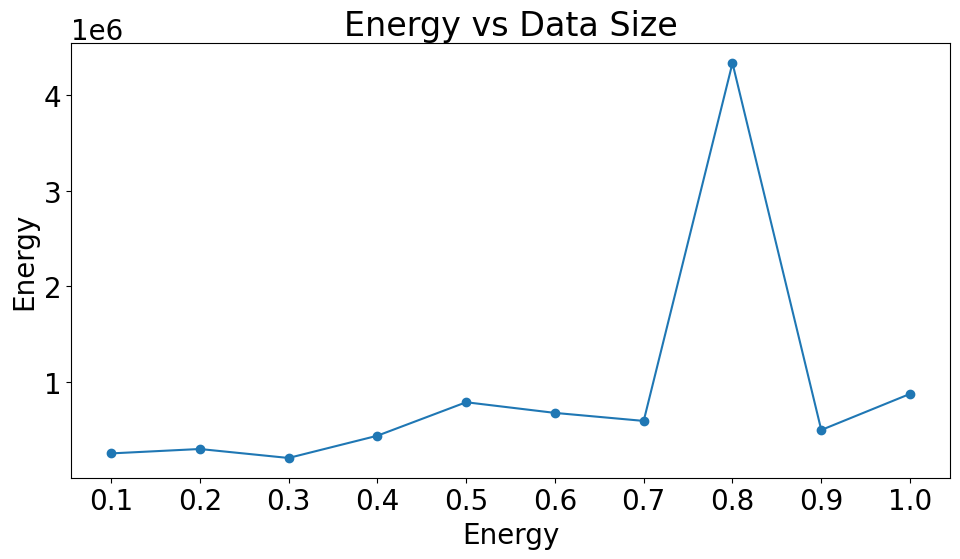

In [34]:
# Plotting graph for Sum of Fitness vs num_irs_ele
irs_element_values =np.arange(0.1, 1.1, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(irs_element_values, fitness_sums_HC, marker='o', linestyle='-')
plt.xlabel('Energy')
plt.ylabel('Energy')
plt.title('Energy vs Data Size')
plt.xticks(irs_element_values)
plt.tight_layout()
plt.show()

In [27]:
num_bs = 5
num_irs_ele=50
num_generation = 1 # Number of generations, increased for GA to evolve
num_uav_irs = 8
population_size = 50 # Population size for GA

# Define keys that should be subjected to crossover and mutation (numerical parameters)
numerical_keys_for_crossover = [
    'P_m_down_value', 'P_m_har_value', 'T_m_har_value',
    'f_km_value', 'V_lm_vfly_value', 'V_lm_hfly_value',
    'P_km_up_value','f_km_value','Angle1_row','Angle_row',
    'Angle2_row',
]

fitness_sums_GA= [] # Store sum of fitness values for each p_max

D_m_values = np.arange(0.1, 1.1, 0.1) # D_km values from 0.1 to 1

for D_m_current in D_m_values: # Iterate over D_km values
    print(f"calculaiton for Dm",D_m_current)
    all_best_combinations = []
    all_best_individuals = []

    # Main Genetic Algorithm Loop
    for l in range(num_bs):
        all_best_individuals_bs = []
        P_m_har_value = P_m_har.values[l]
        T_m_har_value = T_m_har.values[l]
        P_m_down_value = P_m_down.values[l]

        # Select unique row indices for the current BS

        index_list = list(range(num_rows_data_files)) # Create a list of all indices
        random.shuffle(index_list)
        unique_row_indices = index_list[:population_size]
        # Create dataframes with uniquely selected rows for the current BS

        h_l_km_df_bs = h_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        g_l_km_df_bs = g_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        f_l_km_df_bs = f_l_km_df.iloc[unique_row_indices, :].reset_index(drop=True)
        f_km_bs = f_km[unique_row_indices].reset_index(drop=True)
        # Corrected line: Ensure indices are within bounds of P_km_up
        valid_indices = [i for i in unique_row_indices if i < len(P_km_up)]
        P_km_up_bs = P_km_up.iloc[valid_indices].reset_index(drop=True)


        for k in range(num_uav_irs):
            best_fitness = float('inf')
            best_individual = {}
            population = []
            V_lm_vfly_value = V_lm_vfly.values[k]
            V_lm_hfly_value = V_lm_hfly.values[k]
            Wl_value = Wl
            Sub_value=0
            # Corrected loop range to use valid_indices length
            for i in range(len(valid_indices)): # Using length of valid_indices
                h_il_up_value=h_kml_down(Angle_UP_df.iloc[i, :],g_l_m_df.iloc[k, :],g_l_km_df_bs.iloc[i, :]) # Pass Series, corrected index to i
                Sub_value+=sub(P_km_up_bs[i],h_il_up_value)

            # Initialize population
            # Corrected loop range to use valid_indices length
            for i in range(len(valid_indices)): # Using length of valid_indices
                f_km_value = f_km_bs[i] # Use BS-specific f_km
                P_km_up_value = P_km_up_bs[i] # Use BS-specific P_km_up

                Angle_row = Angle_df.iloc[i, :] # Use BS-specific Angle_df
                h_l_m_row = h_l_m_df.iloc[k, :] # Use BS-specific h_l_m_df
                h_l_km_row = h_l_km_df_bs.iloc[i, :] # Use BS-specific h_l_km_df
                Angle1_row = Angle_UP_df.iloc[i, :] # Use BS-specific Angle_UP_df
                g_l_m_row = g_l_m_df.iloc[k, :] # Use BS-specific g_l_m_df
                g_l_km_row = g_l_km_df_bs.iloc[i, :] # Use BS-specific g_l_km_df
                Angle2_row = Angle_har_df.iloc[i, :] # Use BS-specific Angle_har_df
                f_l_m_row = f_l_m_df.iloc[k, :] # Use BS-specific f_l_m_df
                f_l_km_row = f_l_km_df_bs.iloc[i, :] # Use BS-specific f_l_km_df

                # Calculate power values
                P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                # Calculate time and energy values
                T_l_vfly_value = H_value / V_lm_vfly_value
                T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                E_ml_har_value = P_m_har_value * T_m_har_value
                h_kml_down_value=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Pass Series
                h_ml_worst_value=h_ml_worst(h_kml_down_value,sigma_km)
                R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                T_ml_down_value=D_m_current/R_ml_down_value
                E_ml_down_value = P_m_down_value * T_ml_down_value
                T_km_com_value = D_km / f_km_value
                h_kml_up_value=h_kml_down(Angle1_row,g_l_m_row,g_l_km_row) # Pass Series, using same function, might need different one if logic is different

                R_kml_up_value=R_kml_up(B,P_km_up_value,h_kml_up_value,Sub_value,sigma_km)
                T_km_up_value=D_m_current/R_kml_up_value # equation number 5
                T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)

                # Calculate fitness
                result_fitness = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)

                # Store initial population data
                population.append({
                    'fitness': result_fitness,
                    'data':  {
                        'P_m_down_value': P_m_down_value,
                        'P_m_har_value': P_m_har_value,
                        'T_m_har_value': T_m_har_value,
                        'f_km_value': f_km_value,
                        'T_km_up_value': T_km_up_value,
                        'V_lm_vfly_value': V_lm_vfly_value,
                        'V_lm_hfly_value': V_lm_hfly_value,
                        'P_km_up_value':P_km_up_value,
                        'Angle1_row':Angle1_row,
                        'Angle_row':Angle_row,
                        'Angle2_row': Angle2_row,
                        }
                    })

            generations_data = []
            for j in range(num_generation):
                child_population = []
                # Corrected loop range to use valid_indices length
                for x in range(0, len(valid_indices), 2): # Loop through population with step of 2
                    if x + 1 >= len(valid_indices): # Check if i+1 is within bounds, if not break to avoid error in accessing population[i+1]
                        break
                    # Crossover
                    ranodmpopulation=[]
                    for i in range(10):
                        ranodmpopulation.append(random.choice(population))
                    ranodmpopulation = sorted(ranodmpopulation, key=lambda x: x['fitness'])
                    parent1 = ranodmpopulation[0]
                    parent2 = ranodmpopulation[1]
                    child_data = {}
                    for key in parent1['data']:

                        if key in numerical_keys_for_crossover: # Apply crossover only to numerical keys
                            if isinstance(parent1['data'][key], (pd.Series, np.ndarray)): # Check for both Series and NumPy array
                                child_data[key] = float(parent1['data'][key].iloc[0]) * 0.6 + float(parent2['data'][key].iloc[0]) * (1 - 0.6)
                            else:
                                child_data[key] = float(parent1['data'][key]) * 0.6 + float(parent2['data'][key]) * (1 - 0.6)
                        else:
                            # For non-numerical keys (like index lists, angle rows), simply copy from parent1
                            child_data[key] = parent1['data'][key]


                    # Mutation
                    u = np.random.uniform(0, 1, 1)[0]
                    P_mutation = 0.5
                    if u < P_mutation:
                        for key in numerical_keys_for_crossover: # Apply mutation only to numerical keys
                            child_data[key] += random.normal(loc=0, scale=1, size=(1))[0]

                    # Compute child fitness
                    def compute_fitness(data):
                        P_m_down_value = data['P_m_down_value']
                        P_m_har_value = data['P_m_har_value']
                        T_m_har_value = data['T_m_har_value']
                        f_km_value = data['f_km_value']
                        T_km_up_value = data['T_km_up_value']
                        V_lm_vfly_value = data['V_lm_vfly_value']
                        V_lm_hfly_value = data['V_lm_hfly_value']
                        P_km_up_value=data['P_km_up_value']
                        Angle_row = data['Angle_row'] # Retrieve angle row from child data
                        Angle1_row = data['Angle1_row'] # Retrieve angle row from child data
                        Angle2_row = data['Angle2_row'] # Retrieve angle row from child data

                        # Calculate power values
                        P_lm_blade_value = P_lm_blade(Nr, p_l_b, V_tip, V_lm_hfly_value)
                        P_lm_fuselage_value = P_lm_fuselage(Cd, Af, Bh, V_lm_hfly_value)
                        P_lm_induced_value = P_lm_induced(Nr, Bh, Ar, Wl_value, V_lm_vfly_value)

                        # Calculate time and energy values
                        T_l_vfly_value = H_value / V_lm_vfly_value
                        T_l_hfly_value = D_l_hfly_value / V_lm_hfly_value # Corrected: D_l_hfly / V_lm_hfly
                        E_ml_har_value = P_m_har_value * T_m_har_value # Corrected: 


                        h_kml_down_value_compute=h_kml_down(Angle_row,h_l_m_row,h_l_km_row) # Using original Angle_row, h_l_m_row, h_l_km_row for child as well - might need to be based on child data if angles are also part of optimization
                        h_ml_worst_value=h_ml_worst(h_kml_down_value_compute,sigma_km)
                        R_ml_down_value=R_ml_down(B,P_m_down_value,h_ml_worst_value)
                        if R_ml_down_value <= 0: # check if R_ml_down_value is zero or negative
                            R_ml_down_value = 1e-9 # Assign a small positive value to avoid division by zero
                        T_ml_down_value=D_m_current/R_ml_down_value
                        E_ml_down_value = P_m_down_value * T_ml_down_value
                        T_km_com_value = D_km / f_km_value
                        T_lm_hov_value = T_lm_hov(T_km_com_value, T_km_up_value, T_ml_down_value)
                        P_l_hov_value = P_l_hov(Wl_value, p_l_b, Nr, Ar, Bh)
                        P_l_vfly_value = P_l_vfly(Wl_value, V_lm_vfly_value, p_l_b, Nr, Ar, Bh)
                        P_lm_hfly_value = P_lm_hfly(P_lm_blade_value, P_lm_fuselage_value, P_lm_induced_value)
                        E_ml_UAV_value = E_ml_UAV(P_l_vfly_value, T_l_vfly_value, P_lm_hfly_value, T_l_hfly_value, P_l_hov_value, T_lm_hov_value)
                        h_kml_har_value_compute=h_kml_down(Angle2_row,f_l_m_row,f_l_km_row) # Corrected index to Angle2_row
                        E_kml_har_value=E_kml_har(P_m_har_value,T_m_har_value,h_kml_har_value_compute) # Corrected function call for E_kml_har
                        E_kml_com_value = E_km_com(f_km_value, T_km_com_value)
                        E_kml_up_value=E_kml_up(P_km_up_value,T_km_up_value)


                        # Calculate fitness
                        fitness_value = Fitness(E_ml_har_value, E_ml_down_value, E_ml_UAV_value)
                        current_data = {
                            'P_m_down_value': P_m_down_value,
                            'P_m_har_value': P_m_har_value,
                            'T_m_har_value': T_m_har_value,
                            'f_km_value': f_km_value,
                            'T_km_up_value': T_km_up_value,
                            'V_lm_vfly_value': V_lm_vfly_value,
                            'V_lm_hfly_value': V_lm_hfly_value,
                            'P_km_up_value':P_km_up_value,
                            'Angle1_row':Angle1_row,
                            'Angle_row':Angle_row,
                            'Angle2_row': Angle2_row, # Carry forward original index
                                                        }
                        if V_lm_hfly_value>0 and T_m_har_value>0 and T_ml_down_value>0 and T_km_up_value>0 and P_m_har_value<=p_max and P_m_down_value<=p_max and P_km_up_value<=p_km_max and (T_km_com_value+T_km_up_value+T_ml_down_value)<=T_m and f_km_value>0  and E_kml_har_value>=(E_kml_up_value+E_kml_com_value) and V_lm_vfly_value>0:
                            return fitness_value, current_data
                        else:
                            return  float('inf'),{} # Return empty dict instead of float('inf') for data

                    child_fitness, child_data1 = compute_fitness(child_data)
                    child_population.append({'fitness': child_fitness, 'data': child_data1})

                # Create new population
                new_population = population + child_population
                new_population = sorted(new_population, key=lambda x: x['fitness'])
                population = new_population[:population_size]
                generations_data.append(population[0].copy())
                # print(population[0])

            best_individual_pair = population[0].copy()
            best_individual_pair['generation'] = j + 1 # Use last j from loop, corrected index
            best_individual_pair['type'] = 'GA'
            best_individual_pair['bs_index'] = l
            best_individual_pair['uav_index'] = k
            all_best_individuals_bs.append(best_individual_pair)

            all_best_combinations.append({
                'bs_index': l,
                'uav_index': k,
                'best_fitness': population[0]['fitness'],
                'best_individual': best_individual_pair,
                'generation_fitness': [gen['fitness'] for gen in generations_data],
                'unique_row_indices': unique_row_indices # Store unique_row_indices in best_combinations
            })
            # print(f"Best Fitness for BS {l}, UAV {k}: {population[0]['fitness']:.4f}")

        # Find best individual for current BS across all UAVs
        best_individual_for_bs = min(all_best_individuals_bs, key=lambda x: x['fitness'])
        # print(f"Best Fitness for BS {l} across all UAVs: {best_individual_for_bs['fitness']:.4f}")


    # Select the best unique Base station and UAV-IRS pair using Auction based method
    combination_lookup = {}
    for combination in all_best_combinations:
        if combination['bs_index'] not in combination_lookup:
            combination_lookup[combination['bs_index']] = {}
        combination_lookup[combination['bs_index']][combination['uav_index']] = combination

    # Auction-based assignment
    best_assignments = []
    unassigned_bs = list(range(num_bs))
    unassigned_uavs = list(range(num_uav_irs))

    while unassigned_bs and unassigned_uavs:
        best_combination_overall = None

        for l in unassigned_bs:
            best_fitness_for_bs = float('inf')
            best_combination_for_bs = None
            for k in unassigned_uavs:
                if l in combination_lookup and k in combination_lookup[l]:
                    combination = combination_lookup[l][k]
                    if combination['best_fitness'] < best_fitness_for_bs: # Use 'best_fitness' instead of 'best_individual']['fitness']
                        best_fitness_for_bs = combination['best_fitness']
                        best_combination_for_bs = combination

            if best_combination_for_bs:
                if best_combination_overall is None or best_combination_for_bs['best_fitness'] < best_combination_overall['best_fitness']: # Compare with current best overall
                    best_combination_overall = best_combination_for_bs

        if best_combination_overall:
            best_assignments.append(best_combination_overall)
            unassigned_bs.remove(best_combination_overall['bs_index'])
            unassigned_uavs.remove(best_combination_overall['uav_index'])

    # Print and Plotting
    print(f"\n--- Best Unique UAV Assignments (Auction Based Method) ---")
    best_pair_for_plot = None
    min_fitness_for_plot = float('inf')

    sum_fitness_current_p_max = 0 # Sum of best fitness for current p_max
    for assignment in best_assignments:
        print(f"\nBest Assignment for BS {assignment['bs_index']}:")
        print(f" UAV Index: {assignment['uav_index']}")
        best_ind = assignment['best_individual']
        print(f" Best Individual:")
        print(f"  Generation: {best_ind['generation']}, Type: {best_ind['type']}")
        print(f"  Fitness: {best_ind['fitness']:.4f}") # Print current best fitness only
        unique_indices_to_print = assignment['unique_row_indices'] # Retrieve unique_row_indices
        for key, value in best_ind['data'].items():
            if isinstance(value, pd.Series):
                print(f"  {key}: Series: \n{value.iloc[unique_indices_to_print]}") # Print sliced Series
            elif isinstance(value, list): # Handle list type values explicitly
                print(f"  {key}: {value}") # print list directly without formatting
            else:
                print(f"  {key}: {value:.4f}") # Format scalar values

        print("-" * 20)
        sum_fitness_current_p_max += best_ind['fitness'] # Sum fitness values

        if assignment['best_individual']['fitness'] < min_fitness_for_plot:
            min_fitness_for_plot = assignment['best_individual']['fitness']
            best_pair_for_plot = assignment

    fitness_sums_GA.append(sum_fitness_current_p_max) # Store sum of fitness for this p_max

    # Unassigned BS/UAVs
    if unassigned_bs:
        print("\n--- Base Stations without Assigned UAVs ---")
        for bs_index in unassigned_bs:
            print(f"  BS {bs_index} : No UAV is assigned")
            print("-" * 20)

    if unassigned_uavs:
        print("\n--- UAVs without Assigned Base Stations ---")
        for uav_index in unassigned_uavs:
            print(f"  UAV {uav_index} : No BS is assigned")
            print("-" * 20)

calculaiton for Dm 0.1

--- Best Unique UAV Assignments (Auction Based Method) ---

Best Assignment for BS 4:
 UAV Index: 6
 Best Individual:
  Generation: 1, Type: GA
  Fitness: 16001.7862
  P_m_down_value: 0.5754
  P_m_har_value: 0.8595
  T_m_har_value: 0.3629
  f_km_value: 0.9824
  T_km_up_value: 0.1695
  V_lm_vfly_value: 97.1460
  V_lm_hfly_value: 23.5466
  P_km_up_value: 9.3996
  Angle1_row: Series: 
403     14.218936
291     14.913899
367    151.464381
117    113.399607
482    151.530307
120     57.317660
398     92.513759
452     48.583455
128     72.991106
75     140.400178
180    146.741327
409    114.230304
273    178.063673
200     16.785114
167     91.388009
290    146.068369
349     73.243387
320     98.867893
115    159.933794
12       5.673685
238     76.741081
337    166.400837
40      73.748999
406    107.150404
69      51.117839
55      99.915531
373    151.859253
340    102.187578
315      0.614281
303     64.946879
13      45.262277
229     74.415448
260    127.1962

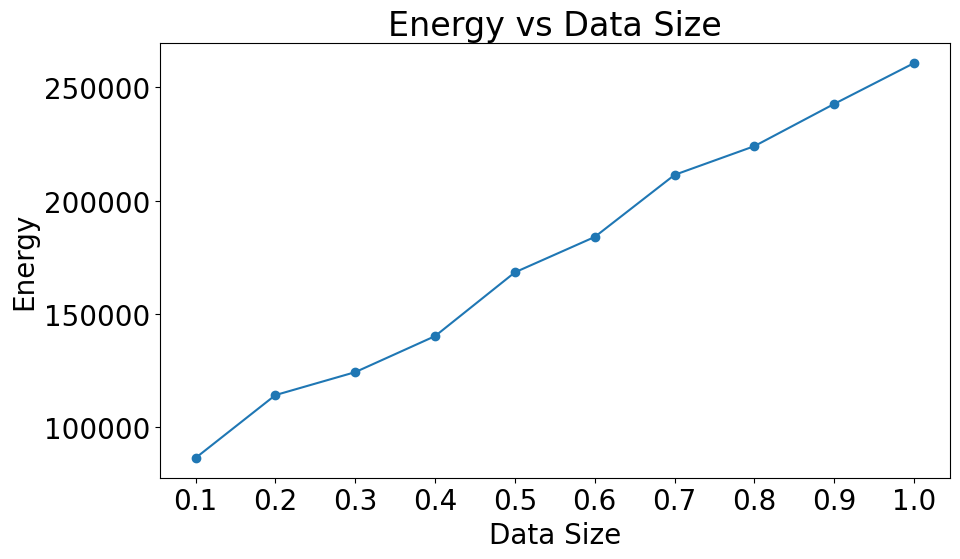

In [32]:
# Plotting graph for Sum of Fitness vs num_irs_ele
irs_element_values =np.arange(0.1, 1.1, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(irs_element_values, fitness_sums_GA, marker='o', linestyle='-')
plt.xlabel('Data Size')
plt.ylabel('Energy')
plt.title('Energy vs Data Size')
plt.xticks(irs_element_values)
plt.tight_layout()
plt.show()

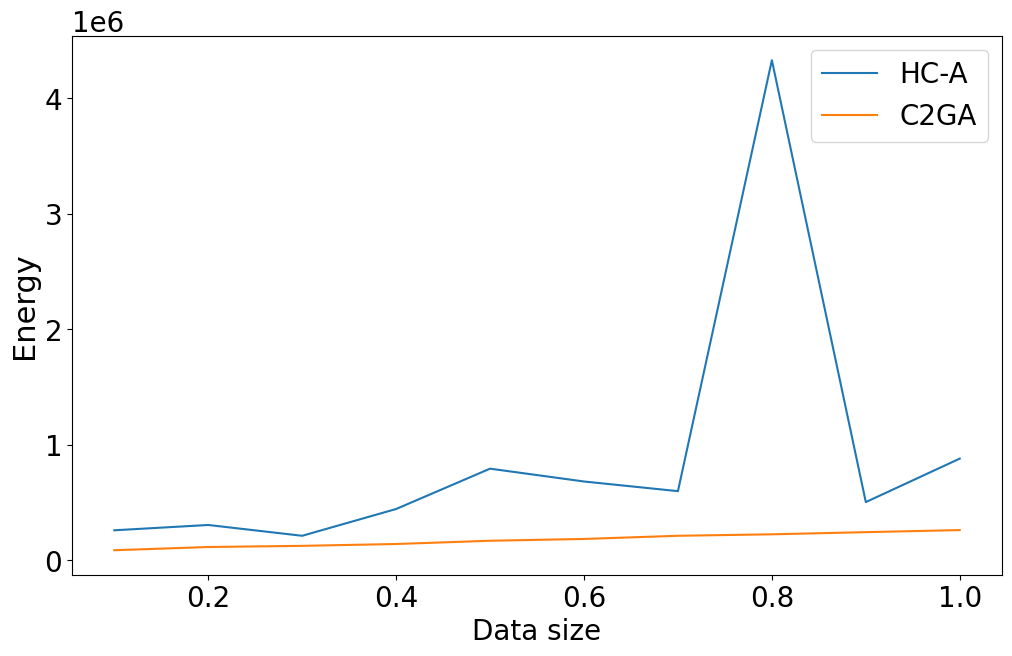

In [29]:
plt.figure(figsize=(12, 7))
T_m_range = np.arange(0.1, 1.1, 0.1)

plt.rcParams["font.size"] = "20"
plt.plot(T_m_range, fitness_sums_HC, label = "HC-A")
plt.plot(T_m_range, fitness_sums_GA, label = "C2GA")
plt.xlabel('Data size',size=20)
plt.ylabel('Energy',size=22)
plt.legend()
plt.savefig("Energy vs Data size.pdf", format="pdf", bbox_inches="tight", dpi=800)
plt.show()


In [30]:

percentage_improvements = []
better_algorithm_counts = {'HC-A': 0, 'C2GA': 0, 'Tie': 0}
average_percentage_improvement_HC_A = 0
average_percentage_improvement_C2GA = 0

print("\n--- Algorithm Comparison ---")
for i in range(len(T_m_range)):
    hc_a_fitness = fitness_sums_HC[i]
    c2ga_fitness = fitness_sums_GA[i]
    data_size = T_m_range[i]

    if hc_a_fitness < c2ga_fitness:
        better_fitness = hc_a_fitness
        worse_fitness = c2ga_fitness
        better_algorithm = "HC-A"
        worse_algorithm = "C2GA"
        better_algorithm_counts['HC-A'] += 1
    elif c2ga_fitness < hc_a_fitness:
        better_fitness = c2ga_fitness
        worse_fitness = hc_a_fitness
        better_algorithm = "C2GA"
        worse_algorithm = "HC-A"
        better_algorithm_counts['C2GA'] += 1
    else:
        better_algorithm = "Tie"
        better_algorithm_counts['Tie'] += 1
        percentage_improvement = 0 # No improvement if it's a tie
        percentage_improvements.append(percentage_improvement) # Append 0 for tie
        print(f"Data size {data_size:.1f}: Tie in Energy ({hc_a_fitness:.2f} vs {c2ga_fitness:.2f}) - 0.00% Improvement")
        continue # Skip percentage calculation for tie

    percentage_improvement = ((worse_fitness - better_fitness) / worse_fitness) * 100
    percentage_improvements.append(percentage_improvement)

    print(f"Data size {data_size:.1f}: {better_algorithm} is better by {percentage_improvement:.2f}% (Energy: {better_fitness:.2f} vs {worse_fitness:.2f})")


# Calculate average percentage improvement for cases where HC-A is better
hc_a_improvements = [p for i, p in enumerate(percentage_improvements) if fitness_sums_HC[i] < fitness_sums_GA[i]]
if hc_a_improvements:
    average_percentage_improvement_HC_A = np.mean(hc_a_improvements)

# Calculate average percentage improvement for cases where C2GA is better
c2ga_improvements = [p for i, p in enumerate(percentage_improvements) if fitness_sums_GA[i] < fitness_sums_HC[i]]
if c2ga_improvements:
    average_percentage_improvement_C2GA = np.mean(c2ga_improvements)


print("\n--- Summary ---")
print("Algorithm Performance Comparison:")
print(f"  HC-A was better in {better_algorithm_counts['HC-A']} out of {len(T_m_range)} cases.")
print(f"  C2GA was better in {better_algorithm_counts['C2GA']} out of {len(T_m_range)} cases.")
print(f"  Tie in {better_algorithm_counts['Tie']} out of {len(T_m_range)} cases.")

if better_algorithm_counts['HC-A'] > better_algorithm_counts['C2GA']:
    if hc_a_improvements:
        print(f"\nOverall, HC-A (Hill Climbing) is generally better.")
        print(f"On average, when HC-A is better, it reduces energy consumption by approximately {average_percentage_improvement_HC_A:.2f}%.")

elif better_algorithm_counts['C2GA'] > better_algorithm_counts['HC-A']:
    if c2ga_improvements:
        print(f"\nOverall, C2GA (Genetic Algorithm) is generally better.")
        print(f"On average, when C2GA is better, it reduces energy consumption by approximately {average_percentage_improvement_C2GA:.2f}%.")
else:
    print("\nOverall, both algorithms perform similarly on average based on the number of better cases.")



--- Algorithm Comparison ---
Data size 0.1: C2GA is better by 66.66% (Energy: 86320.68 vs 258906.71)
Data size 0.2: C2GA is better by 62.57% (Energy: 114102.11 vs 304877.76)
Data size 0.3: C2GA is better by 41.20% (Energy: 124245.69 vs 211306.00)
Data size 0.4: C2GA is better by 68.38% (Energy: 140162.36 vs 443289.67)
Data size 0.5: C2GA is better by 78.76% (Energy: 168335.21 vs 792580.86)
Data size 0.6: C2GA is better by 73.00% (Energy: 183967.73 vs 681391.79)
Data size 0.7: C2GA is better by 64.64% (Energy: 211394.30 vs 597755.58)
Data size 0.8: C2GA is better by 94.82% (Energy: 224087.98 vs 4329455.56)
Data size 0.9: C2GA is better by 51.75% (Energy: 242752.46 vs 503104.09)
Data size 1.0: C2GA is better by 70.36% (Energy: 260783.48 vs 879725.58)

--- Summary ---
Algorithm Performance Comparison:
  HC-A was better in 0 out of 10 cases.
  C2GA was better in 10 out of 10 cases.
  Tie in 0 out of 10 cases.

Overall, C2GA (Genetic Algorithm) is generally better.
On average, when C2GA is